# Imports, type in the protein to be display

In [13]:
%ls

 Volume in drive C is Windows
 Volume Serial Number is 6AD8-7117

 Directory of C:\Users\scaparas\WWK_Lab_22_Copy

11/03/2022  05:54 PM    <DIR>          .
11/03/2022  05:54 PM    <DIR>          ..
11/01/2022  03:52 PM    <DIR>          .ipynb_checkpoints
10/02/2022  07:44 PM           203,022 101m.pdb
10/06/2022  06:24 PM       793,453,726 101m_trajectory.pdb
10/06/2022  05:04 PM           217,864 102l.pdb
10/12/2022  05:34 PM       790,501,726 102l_trajectory.pdb
10/18/2022  06:56 PM           216,716 107l.pdb
10/19/2022  04:39 AM       804,589,321 107l_trajectory.pdb
10/27/2022  09:42 PM           165,282 134l.pdb
10/28/2022  08:48 PM       689,264,521 134l_trajectory.pdb
10/28/2022  12:16 PM           234,500 153l.pdb
10/28/2022  01:36 PM           148,230 184l.pdb
10/12/2022  05:31 PM         3,014,901 1a57.pdb
10/14/2022  12:01 AM     1,187,176,069 1a57_trajectory.pdb
10/13/2022  04:46 PM           276,858 1a8a.pdb
10/14/2022  12:01 AM       590,634,921 1a8a_trajectory.pdb
03/11/

In [31]:
from simtk.openmm.app import *
from simtk.openmm import *
from simtk.unit import *
from sys import stdout
from time import time
#type in the name of the protein you're working with (e.g. 1yiy, 3hfb)
the_protein = '1a44'

# PDB fixer excerpt that gets rogue PDB files working working
Note you need to change the filename in THREE places for each new protein structure

pdbfixer fixes issues with missing residues, missing H atoms, and adds in solvent


In [33]:
from pdbfixer import PDBFixer
from simtk.openmm.app import PDBFile
protein_file = the_protein + '.pdb'
fixer = PDBFixer(filename= protein_file)
numChains = len(list(fixer.topology.chains()))  #these two lines remove all chains but the first
fixer.removeChains(range(1, numChains)) #these two lines remove all chains but the first
fixer.findMissingResidues()
fixer.findNonstandardResidues()
fixer.replaceNonstandardResidues()
fixer.removeHeterogens(False)  #the "false" also removes waters
fixer.findMissingAtoms()
fixer.addMissingAtoms()
#changed to 9.0
fixer.addMissingHydrogens(7.0)
# fixer.addSolvent(fixer.topology.getUnitCellDimensions(), positiveIon='Na+', negativeIon='Cl-', ionicStrength=0.0*molar)
PDBFile.writeFile(fixer.topology, fixer.positions, open(protein_file, 'w'))
print('Done writing fixed PDB')
print('Done adding solvent')

Done writing fixed PDB
Done adding solvent


# Load a structure and set up the simulation parameters and data structures

In [34]:
protein = PDBFile(the_protein + '.pdb')
forcefield = ForceField('amber14/protein.ff14SB.xml', 'amber14/tip3p.xml')
# Create Modeller object  This Modeller object will be used in place of the
# actual pdb file.
protein_model = Modeller(protein.topology, protein.positions)

# Add a tip3p waterbox solvent
protein_model.addSolvent(forcefield, model = 'tip3p', padding = 1.5*nanometers)

In [35]:
# Create and setup the system/environment as well as the integrator
# to be used in the simulation. Values will be recorded at every femtosecond
# (1 femtosecond = 1 timestep), and the system will be set to stay at around
# 296 Kelvin

system = forcefield.createSystem(protein_model.topology, nonbondedMethod = PME, 
                                 nonbondedCutoff = 1.0*nanometers, constraints = HBonds)
integrator = LangevinIntegrator(296*kelvin, 1.0/picosecond, 1.0*femtosecond)

# Specify the platform/processor that will be used to run the simulation on.
# Since the average person will be doing these simulations on their own computer
# with no special modifications, 'CPU' will be the only platform one wll be able
# to use.
platform = Platform.getPlatformByName('CPU')

# Initialize the simulation with the required topology, system, integrator, and
# platform, as well as set the positions of the molecules in the simulation.
simulation = Simulation(protein_model.topology, system, integrator, platform)
simulation.context.setPositions(protein_model.positions)

# Minimization: provides an initial low energy structure

In [36]:

# Get the initial state of the system and print out the values for
# potential and kinetic energy
st = simulation.context.getState(getPositions=True, getEnergy=True, enforcePeriodicBox=True)
print("Potential energy before minimization is %s" % st.getPotentialEnergy())
print("Kinetic energy before minimization is %s" % st.getKineticEnergy())

# Minimize the simulation for at most 100 iterations (the simulation 
# can potentially stop minimizing if the kinetic energy has been sufficiently
# minimized before it reaches 100 iterations, although you won't be able
# to tell), while also taking note of how long it takes for the minimization to
# finish.
print('Minimizing...')
tinit = time()
simulation.minimizeEnergy(maxIterations=100)
tfinal = time()

# Get the new state of the system and print out the values for
# potential and kinetic energy.
st = simulation.context.getState(getPositions=True,getEnergy=True, enforcePeriodicBox=True)
print("Potential energy after minimization is %s" % st.getPotentialEnergy())
print("Kinetic energy after minimization is %s" % st.getKineticEnergy())

# Print out the length of time the minimization took to complete.
print("Done Minimization! Time required: ", tfinal-tinit, "seconds")



Potential energy before minimization is -335668.6920125223 kJ/mol
Kinetic energy before minimization is 8251.323837582811 kJ/mol
Minimizing...
Potential energy after minimization is -654049.3361967647 kJ/mol
Kinetic energy after minimization is 2.4480525972159777 kJ/mol
Done Minimization! Time required:  11.829675912857056 seconds


# Equilibration: sets initial velocities and brings system up to desired temperature

In [37]:
# Set the system to maintain atom velocities such that the temperature of
# the system fluctuates around 296 Kelvin throughout the rest of the 
# equilibration and final simulation.
simulation.context.setVelocitiesToTemperature(296*kelvin)

# Equilibrate the system for 10,000 timesteps while also taking note of 
# how long it takes for the equilibration to finish.
print('Equilibrating...')
tinit = time()
simulation.step(10000)   #number is how many timesteps of equilibration to do
tfinal = time()

# Print out the length of time the equilibration took to complete.
print("Done equilibrating! Time required:", tfinal - tinit, "seconds")

Equilibrating...
Done equilibrating! Time required: 291.7256112098694 seconds


# Production: creates trajectory at desired temperature, starting from end of equilibration

In [ ]:
# Set up simulation to save important values needed for visualization purposes
# to a PDB file and a DCD file, as well as report the timestep, the kinetic
# and potential energies, and the temperature of the system to the standard
# output, every 100 timesteps.
Nsteps=1000000
print_every_Nsteps=5000
simulation.reporters.append(PDBReporter(the_protein + '_trajectory.pdb', print_every_Nsteps))
simulation.reporters.append(StateDataReporter(stdout, print_every_Nsteps, step=True, kineticEnergy=True, 
    potentialEnergy=True, temperature=True, separator='\t'))

# Start the simulation, while also taking note of how long it takes for the
# simulation to finish. When the values are shown in the standard output,
# it will look like the simulation starts at at the 10,000th timestep. That's
# because we are looking at the current state of the system. We already told
# the simulation to go through 10,000 timesteps in the equilibration step, so
# that's what's being reflected here.
tinit = time()
print('Running Production...')
simulation.step(Nsteps)
tfinal = time()
print('Done!')

# Print out the length of time the simulation took to complete.
print('Done production! Time required:', tfinal-tinit, 'seconds')

Running Production...
#"Step"	"Potential Energy (kJ/mole)"	"Kinetic Energy (kJ/mole)"	"Temperature (K)"
15000	-550155.3185490484	107096.799756529	295.7700189266818
20000	-549574.8613836395	107812.97052600981	297.74787300379364
25000	-548873.3933956499	106768.49160735511	294.8633278984186
30000	-549522.9112184492	107503.1816103579	296.8923266788433
35000	-551125.1229723224	105803.56648641244	292.1984871008145
40000	-549098.2154949494	107140.64586461968	295.89110904561466
45000	-547881.0344074786	106849.01073800655	295.0856981732623
50000	-550883.9769858827	106555.60105198443	294.2753864871492
55000	-550016.8140000576	106590.11479226031	294.37070333730566
60000	-550612.9650530749	107127.04037725482	295.8535346711743
65000	-550262.2100953655	106301.0436509147	293.5723734419089
70000	-550096.9834092837	107156.34764528315	295.93447276866306
75000	-550579.8044187055	106676.80014523864	294.61010291366415
80000	-550402.669733213	107297.0819351773	296.3231396912999
85000	-551452.678572048	10742

# Trajectory analysis using the mdtraj package

In [ ]:
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np

In [ ]:
traj = md.load(the_protein + '_trajectory.pdb')
print(traj)

In [ ]:
print('How many atoms?    %s' % traj.n_atoms)   #prints out number of atoms in simulation
print('How many residues? %s' % traj.n_residues)   #prints out number of residues in simulation
print('Second residue: %s' % traj.topology.residue(1))   #prints out the residue label for the number you put in
atom = traj.topology.atom(2)      #picks out a specific atom (based on the number) for further interrogation
print('''Hi! I am the %sth atom, and my name is %s. 
I am a %s atom with %s bonds. 
I am part of an %s residue.''' % ( atom.index, atom.name, atom.element.name, atom.n_bonds, atom.residue.name))

How many atoms?    49059
How many residues? 15642
Second residue: ASN2
Hi! I am the 2th atom, and my name is H2. 
I am a hydrogen atom with 1 bonds. 
I am part of an MET residue.


# Distance analysis

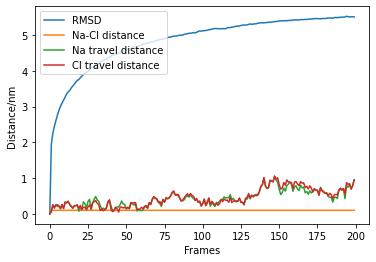

In [ ]:

plt.plot(md.rmsd(traj,traj[0]), label="RMSD")
plt.plot(md.compute_distances(traj,[[0,1]],periodic=True), label="Na-Cl distance")   #distance between atoms 0 and 1
plt.plot(np.sqrt(np.sum((traj.xyz[0, 1, :] - traj.xyz[:, 1, :])**2, axis=1)), label="Na travel distance")  # travel distance for atom 0
plt.plot(np.sqrt(np.sum((traj.xyz[0, 0, :] - traj.xyz[:, 0, :])**2, axis=1)), label="Cl travel distance")  # travel distance for atom 1
plt.xlabel("Frames")
plt.ylabel("Distance/nm")
plt.legend(loc='upper left',fontsize='medium')

In [ ]:
print(np.mean(np.sqrt(np.sum((traj.xyz[:, 0, :] - traj.xyz[:, 1, :])**2, axis=1))))  #prints mean distance between atoms 0 and 1 over the whole trajectory

3.0572684
